<a href="https://colab.research.google.com/github/sayanbanerjee32/feedback-prize-effectiveness/blob/main/all_column_lm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# install fastkaggle if not available
!pip install -Uq fastai
try: import fastkaggle
except ModuleNotFoundError:
    !pip install -Uq fastkaggle

# !pip install -Uq 'timm>=0.6.2.dev'
!pip install -Uq pynvml
from fastkaggle import *

In [4]:
import os
from pathlib import Path
import fastai
fastai.__version__

'2.7.9'

In [5]:
# config depending on whether this is running on kaggle or collab
# is_colab = True
is_colab = not os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
comp = 'feedback-prize-effectiveness'
if is_colab:
    model_save_path = Path('/content/'+comp+'_out/models')
else:
    model_save_path = Path('/kaggle/working/'+comp+'/models')

In [6]:
# import colab libraries
if is_colab:
    from google.colab import drive
    drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so lets move it there.
if is_colab:
    !mkdir ~/.kaggle
    !cp /content/drive/MyDrive/Kaggle_api_auth/kaggle.json ~/.kaggle/

In [8]:
# This permissions change avoids a warning on Kaggle tool startup.
if is_colab:
    !chmod 600 ~/.kaggle/kaggle.json

In [9]:
path = setup_comp(comp)
path

100%|██████████| 8.13M/8.13M [00:00<00:00, 10.9MB/s]


Path('feedback-prize-effectiveness')

In [10]:
from fastai.text.all import *
set_seed(32)

## Language model for original text

In [11]:
# In this cell fastai TextDataLoader functions are overridden to allow taking output 
# directory as input so that the toknised data is not written in data input directory
# in Kaggle, data input directory is read-only
from fastai.text.core import _tokenize_files
@delegates(_tokenize_files)
def tokenize_folderOP(path, extensions=None, folders=None,
                      output_dir=None, skip_if_exists=True, **kwargs):
    """replacement of fastai.text.core.tokenize_folder so that it passes
     output_dir as input to _tokenize_files"""
    path,extensions = Path(path),ifnone(extensions, ['.txt'])
    files = get_files(path, extensions=extensions, recurse=True, folders=folders)
    def _f(i,output_dir): return output_dir/files[i].relative_to(path)
    return _tokenize_files(_f, files, path, output_dir, 
                           skip_if_exists=skip_if_exists, **kwargs)

class TokenizerOP(Tokenizer):
    """Wrapper class for fastai.text.core.Tokenizer class to override
    from_folder method to take output_dir as input and call the overridden
    method tokenize_folderOP"""
    def __init__(self, tok, rules=None, counter=None,
                 lengths=None, mode=None, sep=' '):
        super().__init__(tok, rules=rules, counter=counter,
                 lengths=lengths, mode=mode, sep=sep)
    
    @classmethod
    @delegates(tokenize_folderOP, keep=True)
    def from_folder(cls, path, tok=None, rules=None, output_dir = None, **kwargs):
        path = Path(path)
        if tok is None: tok = WordTokenizer()
        output_dir = tokenize_folderOP(path, tok=tok, rules=rules, 
                                       skip_if_exists = False, 
                                       output_dir = output_dir, **kwargs)
        res = cls(tok, counter=load_pickle(output_dir/fn_counter_pkl),
                  lengths=load_pickle(output_dir/fn_lengths_pkl),
                  rules=rules, mode='folder')
        res.path,res.output_dir = path,output_dir
        return res


class TextBlockOP(TextBlock):
    "Overriding TextBlock for user defined output dir"
    def __init__(self, tok_tfm, vocab=None, is_lm=False,
                 seq_len=72, backwards=False, **kwargs):
        super().__init__(tok_tfm, vocab=vocab, is_lm=is_lm,
                 seq_len=seq_len, backwards=backwards, **kwargs)
    @classmethod
    @delegates(TokenizerOP.from_folder, keep=True)
    def from_folder(cls, path, vocab=None, is_lm=False, seq_len=72,
                    backwards=False, min_freq=3, max_vocab=60000,output_dir =None,
                    **kwargs):
        "Build a `TextBlock` from a `path` - calls TokenizerOP and provides output_dir as input"
        return cls(TokenizerOP.from_folder(path, output_dir = output_dir, **kwargs), vocab=vocab, is_lm=is_lm, seq_len=seq_len,
                   backwards=backwards, min_freq=min_freq, max_vocab=max_vocab)
        
class TextDataLoadersOP(TextDataLoaders):
    "Basic wrapper around several `DataLoader`s with factory methods for NLP problems"
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_folder(cls, path, train='train', valid='valid', valid_pct=None,
                    seed=None, vocab=None, text_vocab=None, is_lm=False,
                    tok_tfm=None, seq_len=72, splitter=None,
                    backwards=False, output_dir =None, **kwargs):
        "This is to override same method from TextDataLoaders to accept and pass output_dir as input"
        if splitter is None:
            splitter = GrandparentSplitter(train_name=train,
                                           valid_name=valid) if valid_pct is None else RandomSplitter(valid_pct,
                                                                                                      seed=seed)
        blocks = [TextBlockOP.from_folder(path, text_vocab, is_lm, seq_len, backwards,
                                          tok=tok_tfm, output_dir = output_dir)]
        if not is_lm: blocks.append(CategoryBlock(vocab=vocab))
        get_items = partial(get_text_files, folders=[train,valid]) if valid_pct is None else get_text_files
        dblock = DataBlock(blocks=blocks,
                           get_items=get_items,
                           splitter=splitter,
                           get_y=None if is_lm else parent_label)
        return cls.from_dblock(dblock, path, path=path, seq_len=seq_len, **kwargs)


In [12]:
tok_path = model_save_path / 'train_tok'
tok_path.mkdir(parents=True, exist_ok=True)
dls_lm = TextDataLoadersOP.from_folder(path / 'train', is_lm=True,
                                       valid_pct=0.1, output_dir = tok_path)
# TextDataLoaders.from_folder(path / 'train', is_lm=True, valid_pct=0.1, )
dls_lm.show_batch(max_n=5)

,text,text_
0,"xxbos xxmaj dear xxmaj principal , \n\n xxmaj community service would be a great thing for every student to be required to do . \n\n xxmaj even though some people may think it is a pretty big time waster , helping the community is doing an act of service , which every student should be able to enjoy . \n\n i believe that doing community service would help the community , make","xxmaj dear xxmaj principal , \n\n xxmaj community service would be a great thing for every student to be required to do . \n\n xxmaj even though some people may think it is a pretty big time waster , helping the community is doing an act of service , which every student should be able to enjoy . \n\n i believe that doing community service would help the community , make students"
1,"technology in order to drive successfully . \n\n xxmaj some pieces of equipment include a video camera , a xxup gps receiver , and multiple sensors . \n\n xxmaj the most important part of the driverless car is the spinning sensor located on the roof . \n\n xxmaj by using laser beams to form a constantly updating 3 - d model , this sensor allows the car to recognize its surroundings .","in order to drive successfully . \n\n xxmaj some pieces of equipment include a video camera , a xxup gps receiver , and multiple sensors . \n\n xxmaj the most important part of the driverless car is the spinning sensor located on the roof . \n\n xxmaj by using laser beams to form a constantly updating 3 - d model , this sensor allows the car to recognize its surroundings . \n\n"
2,"we love to help another community . \n\n xxmaj we need to help other community , we do n't care if they going to help us or not . xxmaj if we help them first then they know who help them . xxmaj next time they going help us back too . xxmaj we have to help them first . xxmaj in xxmaj united states , they do n't need for help","love to help another community . \n\n xxmaj we need to help other community , we do n't care if they going to help us or not . xxmaj if we help them first then they know who help them . xxmaj next time they going help us back too . xxmaj we have to help them first . xxmaj in xxmaj united states , they do n't need for help ."
3,in trouble may many of times . xxmaj one year i was playing softball xxunk up the xxunk arm for the game i did n't have any gear on not even a face mask to protect my face well my phone xxunk in my pocket and i was so exited to see what it was . xxmaj so i looked at the text well the xxunk did n't know that at the,trouble may many of times . xxmaj one year i was playing softball xxunk up the xxunk arm for the game i did n't have any gear on not even a face mask to protect my face well my phone xxunk in my pocket and i was so exited to see what it was . xxmaj so i looked at the text well the xxunk did n't know that at the time
4,up with that idea . xxmaj another reason why i think this is a cool idea is because it knows who you are even when you have on different face expression . xxmaj that 's amazing how a computer can express how we feel .i ' m so xxunk that a computer can do that . i some time ask myself how do they do that . \n\n i think that computers,with that idea . xxmaj another reason why i think this is a cool idea is because it knows who you are even when you have on different face expression . xxmaj that 's amazing how a computer can express how we feel .i ' m so xxunk that a computer can do that . i some time ask myself how do they do that . \n\n i think that computers would


In [13]:
learn_lm = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path=path, wd=0.1).to_fp16()

In [14]:
learn_lm.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.761140,3.472369,0.318289,32.212963,01:49


In [15]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.534518,3.366742,0.333415,28.983940,01:52
1,3.389999,3.261339,0.351225,26.084446,01:52


KeyboardInterrupt: ignored

In [16]:
model_save_path.mkdir(parents=True, exist_ok=True)
learn_lm.save_encoder(model_save_path / 'finetuned')

## Text classification

In [17]:
def file_read(file_path):
    with open(file_path, 'r') as _f: 
        all_content = _f.read()
    return all_content

In [18]:
file_read(path / 'train' / '007ACE74B050.txt')

'Hi, i\'m Isaac, i\'m going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn\'t know if the landform was created by life on Mars, or if it is just a natural landform. On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I\'ll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no life on Mars that we have descovered yet. If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, "It\'s not easy to target Cydonia," in which he is saying that its not easy to know if it is a natural landform at this point. In all that they\'re saying, its probably a natural landf

In [19]:
# pre-process text - add all columns 
df = pd.read_csv(path/'train.csv')
df['essay_text'] = df['essay_id'].apply(lambda x: file_read(path / 'train' / f'{x}.txt'))
df.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_text
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",Lead,Adequate,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no li..."
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform",Position,Adequate,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no li..."
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform because there is no life on Mars that we have descovered yet,Claim,Adequate,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no li..."
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform.",Evidence,Adequate,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no li..."
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by alieans because they thought that there was life on Mars.,Counterclaim,Adequate,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture

In [20]:
# decide sequence length
df['seq_length_essay'] = [len(txt.split()) for txt in df['essay_text'].tolist()]
df['seq_length_dis'] = [len(txt.split()) for txt in df['discourse_text'].tolist()]
df['seq_length_essay'].describe(), df['seq_length_dis'].describe()

(count    36765.000000
 mean       458.588522
 std        220.423420
 min        144.000000
 25%        288.000000
 50%        408.000000
 75%        579.000000
 max       1367.000000
 Name: seq_length_essay, dtype: float64, count    36765.000000
 mean        44.654073
 std         46.669682
 min          1.000000
 25%         16.000000
 50%         28.000000
 75%         57.000000
 max        836.000000
 Name: seq_length_dis, dtype: float64)

In [55]:
# re.compile(df.iloc[0].discourse_text,re.IGNORECASE).sub(df.iloc[0].essay_text, '__MASKED__')
# df.iloc[1].essay_text, df.iloc[1].discourse_text.strip()
# df.iloc[2].essay_text.strip().replace(df.iloc[2].discourse_text.strip(),'__MASKED__')
df['rev_ess_txt'] = df[['essay_text','discourse_text']].apply(lambda row: row.essay_text.strip().replace(row.discourse_text.strip(),
                                                                                                         '__MASKED__'),
                                                              axis = 1)
df['seq_length_rev_ess'] = [len(txt.split()) for txt in df['rev_ess_txt'].tolist()]
df['rev_ess_txt'].head(), df['seq_length_rev_ess'].describe()

(0    __MASKED__ On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform\n\nI think that the face is a natural landform because there is no life on Mars that we have descovered yet. If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, "It's not easy to target Cydonia," in which he is saying that its not easy to know if it is...
 1    Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. __MASKED__\n\nI think that the face is a natural landform because there

In [21]:
# combine all text columns for classification 
# concat all
# df['all_text'] = 'CONTEXT: ' + df.essay_text + '; DISCOURSE: ' + df.discourse_text + '; TYPE: ' + df.discourse_type

df['all_text'] = 'CONTEXT: ' + df.essay_text + '; DISCOURSE: ' + df.discourse_text + '; TYPE: ' + df.discourse_type

In [22]:
# create data loaders
dls = TextDataLoaders.from_df(df, text_col='all_text',
                              label_col='discourse_effectiveness',
                              seq_len=512,
                              text_vocab=dls_lm.vocab)
dls.show_batch(max_n=3)

,text,category
0,"xxbos xxup context : xxmaj to the state and the state 's country , the election of our president must be seen carefully and wisely . xxmaj as the citizens of the state , people must realize that choosing someone to take control of orders and regulations and the way the country xxunk , is a process that needs to be thought of and taken fairly . xxmaj the president is to serve the people of his country well with xxunk that can vary to meet the needs of the country , but the electoral college seems to become more and more unfair to those who vote . xxmaj it must be changed to meet the needs of giving a responisble president , a more trustworthy election and the votes cast must be directly towards him rather than the electors . xxmaj in other words , the xxmaj electoral xxmaj",Effective
1,"xxbos xxup context : xxmaj the xxmaj electoral xxmaj college is best described as outdated and obsolete . xxmaj it was designed so that , when there were too many states and poor technology , the vote could be fairly and xxunk counted , by voting between a few people from each state . xxmaj this was good and efficient for that time , but , with the technology available to us today , it is impractical and easy to corrupt . if you live in a mostly xxmaj democratic state as a xxmaj republican , your vote is regarded as nothing , and you would have no reason to vote in the electoral college , instead of throwing your vote into the entire mass of the united states , where it has a chance to even slightly influence the vote . xxmaj also , since larger states are given",Effective
2,"xxbos xxup context : xxmaj dear state senator , \n\n xxmaj there has been some xxunk between whether we should keep the xxmaj electoral xxmaj college or changing the election to popular vote for the president . xxmaj there are pros and cons to each method of voting . xxmaj the xxmaj electoral xxmaj college has been around since the beginning of our country . xxmaj most of the time it is successful ( there have been a few times problems have occured but rarely it happens ) . xxmaj as time has passed and we enter a more modern age , people have started to feel that the xxmaj electoral xxmaj college does not work and we should all switch to just a regular popular vote . xxmaj however , even though there have been a few problems in the past about this system , the xxmaj electoral xxmaj",Effective


In [23]:
learn = text_classifier_learner(dls, AWD_LSTM, 
                                drop_mult=0.5,
                                metrics=[accuracy,F1Score(average='weighted')]).to_fp16()

learn = learn.load_encoder(model_save_path / 'finetuned')

SuggestedLRs(valley=0.0030199517495930195, slide=0.033113110810518265)

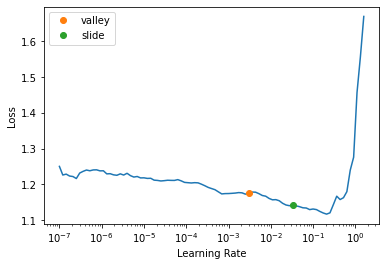

In [24]:
learn.lr_find(suggest_funcs=(valley, slide))

In [25]:
learn.fine_tune(1, 0.01)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.880564,0.787010,0.631579,0.585560,03:25


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.771191,0.693562,0.690466,0.658398,07:40


In [26]:
model_save_path.mkdir(parents=True, exist_ok=True)
learn.export(f'{model_save_path}/basic_lm_text_learner.pkl')

## Test submission

In [ ]:
test_df = pd.read_csv(path/'test.csv')
test_df.rename(columns = {'discourse_text':'text'}, inplace = True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   discourse_id    10 non-null     object
 1   essay_id        10 non-null     object
 2   text            10 non-null     object
 3   discourse_type  10 non-null     object
dtypes: object(4)
memory usage: 448.0+ bytes


In [ ]:
tst_dl = dls.test_dl(test_df)
tst_dl.show_batch()

,text
0,"xxbos xxmaj taking other peoples advice and doing what they say may lead to a great outcome . xxmaj when you receive other opinions whether they are good or bad you will be able to look at them from a different point of view . xxmaj for example , xxmaj when a group of people give you advice on yourself , you then know how they look at you as a person . xxmaj everyone looks at certain things from a different xxunk . xxmaj how someone else looks at it may be how its supposed to be viewed in life ."
1,"xxbos xxmaj everyone is different and may have more experience than you . xxmaj seeking other peoples opinion can cause you to gain a new skill or lesson . xxmaj for example , someones advice could teach you how to do something the correct way . xxmaj many people are very different and have experience different things in life . xxmaj seeking advice from others can teach you a lot . xxmaj we all learn from our mistakes in life , by sharing your past experiences you may prevent someone else from making the same mistake ."
2,xxbos xxmaj when making a decision there is a chance that you can become very stressed and overwhelmed . xxmaj being stressed can cause a person to give up on what they are doing . xxmaj having multiple opinions from people can make choosing an option less difficult and more easier . xxmaj the information that you receive from others may have a special meaning in the future . xxmaj other peoples opinion can make a person feel confident in making the right choice .
3,xxbos xxmaj you can learn from others experiences by seeking the advice that someone give you . xxmaj making decisions can cause stress on a person . xxmaj relating to someones advice may higher your self - esteem because you no longer feel left out . xxmaj ask others for advice when making a difficult decision . xxmaj when you seek others opinion more opportunities are available fro yourself .
4,xxbos xxmaj making choices in life can be very difficult . xxmaj people often ask for advice when they can not decide on one thing . xxmaj it 's always good to ask others for their advice when making a choice . xxmaj when you have multiple opinions you have the ability to make the best choice for yourself .
5,xxbos xxmaj seeking multiple opinions can help a person make a better choice
6,xxbos xxmaj seeking others opinion can be very helpful and beneficial .
7,xxbos a great chance to learn something new
8,xxbos can be very helpful and beneficial .


In [ ]:
probs,_,idxs = learn.get_preds(dl=tst_dl, with_decoded=True)
probs

tensor([[4.0611e-01, 5.9175e-01, 2.1488e-03],
        [8.4944e-01, 9.2870e-02, 5.7692e-02],
        [1.0792e-01, 9.5213e-03, 8.8256e-01],
        [6.6280e-01, 2.1236e-01, 1.2484e-01],
        [1.0792e-01, 9.5213e-03, 8.8256e-01],
        [4.1662e-01, 5.8239e-01, 9.8158e-04],
        [4.0577e-01, 5.9271e-01, 1.5203e-03],
        [8.4476e-01, 5.0534e-02, 1.0471e-01],
        [5.4864e-01, 4.4713e-01, 4.2259e-03],
        [3.0846e-01, 6.9106e-01, 4.7475e-04]])

In [ ]:
# column names for probabilities
probs_df = pd.DataFrame(probs.numpy(),columns = dls.vocab[1])
probs_df

,Adequate,Effective,Ineffective
0,0.406105,0.591746,0.002149
1,0.849438,0.092870,0.057692
2,0.107919,0.009521,0.882559
3,0.662798,0.212361,0.124841
4,0.107919,0.009521,0.882559
5,0.416625,0.582394,0.000982
6,0.405773,0.592707,0.001520
7,0.844760,0.050534,0.104707
8,0.548642,0.447133,0.004226
9,0.308460,0.691065,0.000475


In [ ]:
probs_df["discourse_id"] = test_df["discourse_id"]
probs_df.to_csv('submission.csv', index=False)
!head submission.csv

Adequate,Effective,Ineffective,discourse_id
0.4061053,0.5917459,0.002148808,a261b6e14276
0.8494382,0.092869595,0.057692204,5a88900e7dc1
0.10791949,0.009521278,0.88255924,9790d835736b
0.66279846,0.21236095,0.12484056,75ce6d68b67b
0.10791949,0.009521278,0.88255924,93578d946723
0.4166247,0.58239377,0.0009815764,2e214524dbe3
0.4057729,0.59270686,0.0015202573,84812fc2ab9f
0.8447595,0.05053397,0.10470652,c668ff840720
0.5486415,0.44713268,0.004225909,739a6d00f44a


In [ ]:
# not working for this competetion
# if not iskaggle:
#     from kaggle import api
#     api.competition_submit_cli('submission.csv', 'initial', comp)

In [ ]:
if not iskaggle:
    push_notebook('saan', comp,
                  title='Feedback effeciveness initial model with Language model',
                  file='/content/drive/MyDrive/Colab Notebooks/basic_lm_model.ipynb',
                  competition=comp, private=True, gpu=True)